In [13]:
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time 
import seaborn as sns
from sklearn import cross_validation

In some comments on the forum, the representative for Gruppo Bimbo highlighted returns, and the problem of trying to predict returns. I'm still grappling with understanding the nuances of the dataset, but one question I was interested in was whether returns predict future sales. For example, if there are a lot of returns for a product by a client, will there be less sales for it in the future? If so, then we could use returns - as opposed to just demand - in our model to help forecast future demand.

I decided to inspect a random sample of the histories of some products with some clients in the dataset, watching how the sales and returns changed from week 3 to week 7. Could I see any obvious relationship between returns and future sales? 

In [4]:
# This bit of memory-saving code is from Eric Couto, https://www.kaggle.com/ericcouto/grupo-bimbo-inventory-demand/using-82-less-memory/code
types = {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,
         'Ruta_SAK':np.uint16, 'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint32,
         'Dev_uni_proxima':np.uint32, 'Demanda_uni_equil':np.uint32 }
train = pd.read_csv('../input/train.csv', usecols=types.keys(), dtype=types)
print(train.info(memory_usage=True))
new_names = ["week","depot","channel","route","client","prod","sales_units","return_units_next_week","demand"]
train.columns = new_names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 9 columns):
Semana               uint8
Agencia_ID           uint16
Canal_ID             uint8
Ruta_SAK             uint16
Cliente_ID           uint32
Producto_ID          uint16
Venta_uni_hoy        uint32
Dev_uni_proxima      uint32
Demanda_uni_equil    uint32
dtypes: uint16(3), uint32(4), uint8(2)
memory usage: 1.7 GB
None


In [6]:
def plot_weekly_samples(w, h, pt_sales, pt_returns):
    plt.figure(figsize=[12,12])
    ind = np.arange(len(pt_sales.columns))
    width = 0.3
    for i in range(len(pt_sales)):
        plt.subplot(h,w,i+1)
        plt.bar(left=ind, height=pt_sales.iloc[i], width=width,linewidth=4,color='b',edgecolor='b')
        plt.bar(left=ind+width+0.2, height=pt_returns.iloc[i], width=width,linewidth=4,color='r',edgecolor='r')
        plt.title(pt_sales.iloc[i].name)
        plt.xlim([0,7])
        plt.xticks(ind+width+0.1,pt_sales.columns)
    plt.subplots_adjust(hspace = 0.7, left = 0.05, right = 0.95, bottom = 0.05, top=0.95)

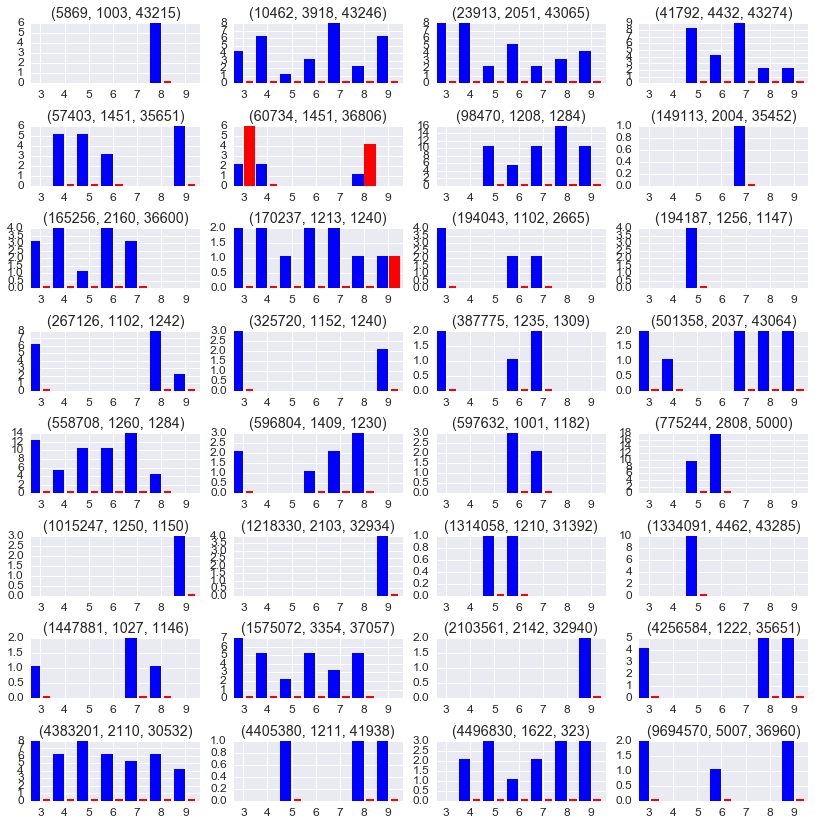

In [14]:
# Number of rows and columns to have in the output
w = 4
h = 8
sample_size = w*h

randseed = 7

# Select a random sample of sample_size rows from the training data
dummy, sample_rows = cross_validation.train_test_split(range(len(train)), test_size=sample_size, train_size=0, random_state=randseed)
selected = train.iloc[sample_rows][['client','route','prod']]

# For each unique client, route, and product combo from those rows, look up all the weeks of data
# associated with them (this will also result in averaging over multiple depots, for example, if there
# are different entries for them)
selected_train = pd.DataFrame()
for i,t in selected.iterrows():
    selected_train = pd.concat([selected_train, train.loc[(train.loc[:,'client']==t.client) & (train.loc[:,'route'] == t.route) & (train.loc[:,'prod'] == t.loc['prod']),:]])

# Make pivot tables for sales and returns with weeks for columns and samples for rows
pt_sales = selected_train.pivot_table(values='sales_units',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)
pt_returns = selected_train.pivot_table(values='return_units_next_week',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)

# Plot these sample product histories in a grid (arbitrarily)
plot_weekly_samples(w, h, pt_sales, pt_returns)

The title of each subplot is the (client, route, product) combination that uniquely specifies it. The horizontal axis is week, the vertical axis is number of units, blue bars indicate sales and red bars indicate returns (placed at the x value of return_units_next_week). When the red bar is barely visible, that means that it was 0. When the blue or red bars are not present that means there were no entries for that week.

Looking at one example of the graphs that are produced, I see first of all not much in the way of trends or predictability in sales by week, so that it probably won't be worth forecasting future weeks based on anything more than the aggregate of sales.

Looking at the returns, the first thing I notice is that they are rare. My intuition is that very few product-client histories are affected by returns. This is borne out by the numbers:

In [8]:
print("Training entries that have any return units at all: %.1f%%" % (100*np.mean(train.return_units_next_week > 0)))

Training entries that have any return units at all: 3.4%


They would appear even rarer if I counted weeks where there were no entries in the training data (probably because there were no sales) Therefore, I decided to just look at those product-client histories where there was at least one return in the target weeks, using the same type of graphs.

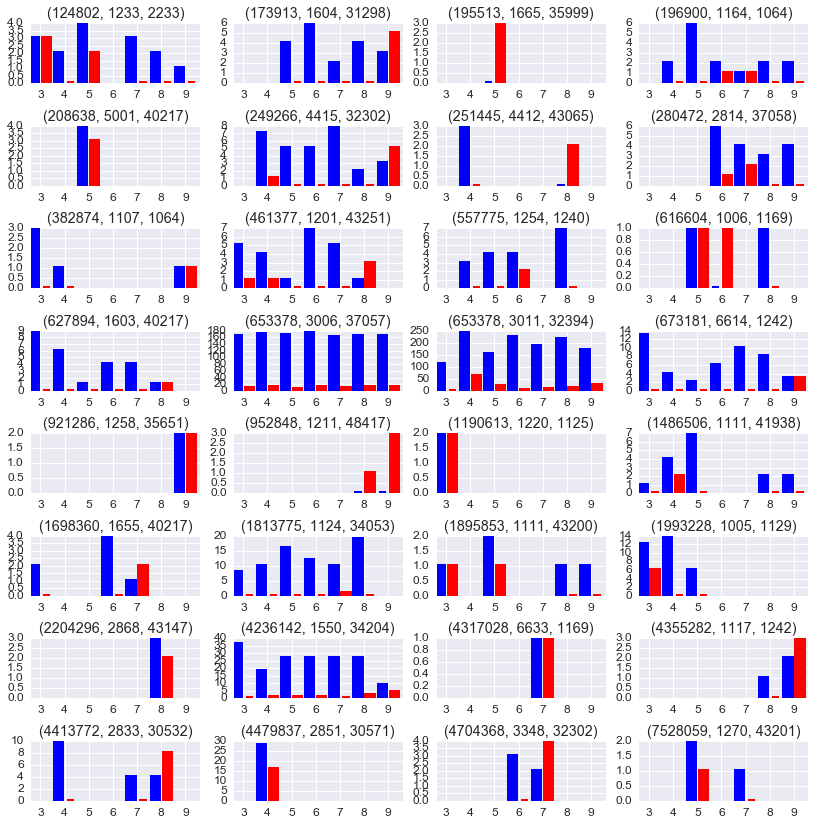

In [15]:
#%%
# Random sample of histories with at least one return

with_returns_indices = np.nonzero(train['return_units_next_week'] >0)[0]
dummy, sample_indices = cross_validation.train_test_split(range(len(with_returns_indices)), test_size=sample_size, train_size=0, random_state=randseed)
sample_rows = with_returns_indices[sample_indices]

selected = train.iloc[sample_rows][['client','route','prod']]

selected_train = pd.DataFrame()
for i,t in selected.iterrows():
    selected_train = pd.concat([selected_train, train.loc[(train.loc[:,'client']==t.client) & (train.loc[:,'route'] == t.route) & (train.loc[:,'prod'] == t.loc['prod']),:]])

pt_sales = selected_train.pivot_table(values='sales_units',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)
pt_returns = selected_train.pivot_table(values='return_units_next_week',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)

plot_weekly_samples(w, h, pt_sales, pt_returns)

Now, looking at client-product histories that had plenty of returns, I see a few possible trends: there seem to often be weeks after the occurrence of returns where there are no sales (only returns, since they occur the week after). Where there are sales later, they appear to be lower after the returns. I also see some returns that are cumulatively larger than the sales during this period, and so must reflect sales from before. 

One other thing I noticed is that there are many entries where only one or two units were sold, and then immediately returned. I made one more of these figures to focus on the histories where more than two returns happened.

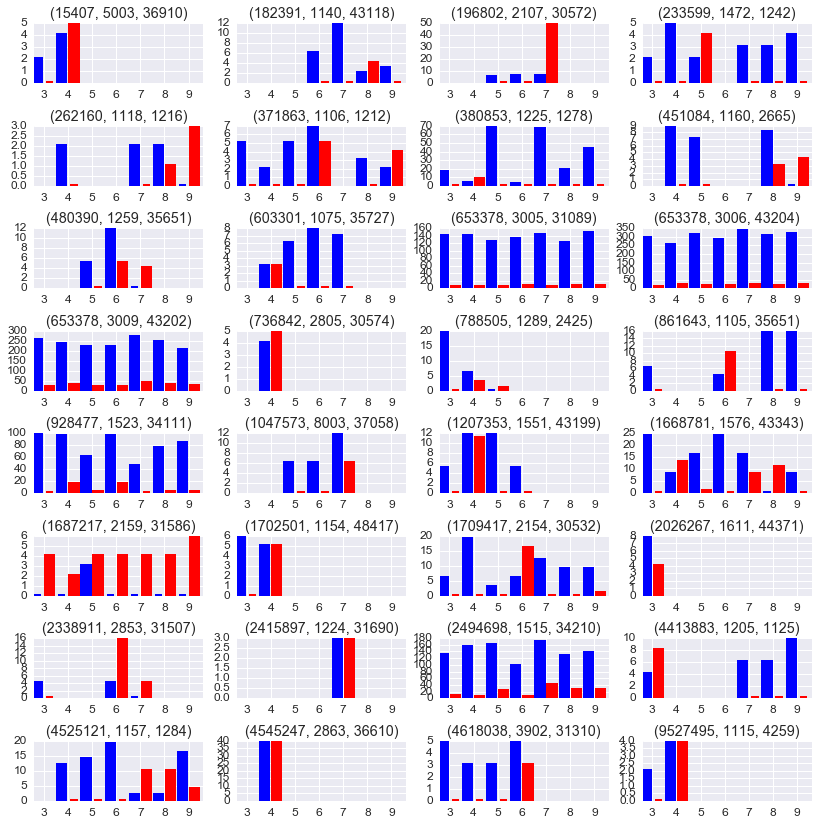

In [16]:
#%%
# Random sample of histories with more than two returns

with_returns_indices = np.nonzero(train['return_units_next_week'] > 2)[0]
dummy, sample_indices = cross_validation.train_test_split(range(len(with_returns_indices)), test_size=sample_size, train_size=0, random_state=randseed)
sample_rows = with_returns_indices[sample_indices]

selected = train.iloc[sample_rows][['client','route','prod']]

selected_train = pd.DataFrame()
for i,t in selected.iterrows():
    selected_train = pd.concat([selected_train, train.loc[(train.loc[:,'client']==t.client) & (train.loc[:,'route'] == t.route) & (train.loc[:,'prod'] == t.loc['prod']),:]])

pt_sales = selected_train.pivot_table(values='sales_units',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)
pt_returns = selected_train.pivot_table(values='return_units_next_week',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)

plot_weekly_samples(w, h, pt_sales, pt_returns)

The same patterns appear to be present: a dropoff in sales after substantial returns. I decided to look at this a bit more systematically, randomly sampling histories with returns from the training dataset as a whole and seeing the impact of a return week on subsequent sales. I decided to focus on client-product histories that had only one week with returns, which appear to be relatively common, to make the impact of the returns clearer. I did not look at the size or percentage of return, but only whether one occurred at all.

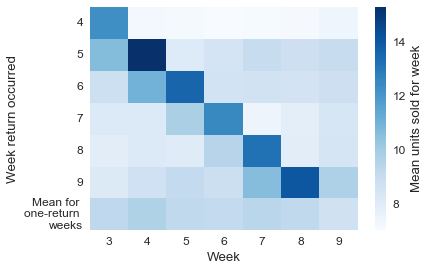

In [17]:
# Make a heatmap of sales relative to weeks where returns occurred, based on a sample 
# from the training set

lerandseed=7
n_samples_for_heatmap = 10000
dummy, sample_indices = cross_validation.train_test_split(range(len(with_returns_indices)), test_size=n_samples_for_heatmap, train_size=0, random_state=randseed)
sample_rows = with_returns_indices[sample_indices]
selected = train.iloc[sample_rows][['client','route','prod']]
selected_train = train.loc[train.loc[:,'client'].isin(selected.client) & train.loc[:,'route'].isin(selected.route) & train.loc[:,'prod'].isin(selected.loc[:,'prod']) ,:]

pt_sales = selected_train.pivot_table(values='sales_units',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)
pt_returns = selected_train.pivot_table(values='return_units_next_week',index=['client','route','prod'],columns=['week'],aggfunc=np.mean)

with_one_return = np.nansum(pt_returns.loc[:,3:8]>0,1) == 1
one_return = pt_returns.iloc[with_one_return,:-1].fillna(0).values # Weeks are columns
one_return_sales = pt_sales.iloc[with_one_return,:].fillna(0).values

return_weeks = np.nonzero(one_return)[1]
week_sales = np.zeros([7,7])
for rw in range(6):
    rows_for_week = (return_weeks==rw)
    values = np.nanmean(one_return_sales[rows_for_week],0)
    week_sales[rw,:] = values
week_sales[-1,:] = np.nanmean(one_return_sales,0)
plt.figure()
yticks = [str(a) for a in range(4,10)] + ["Mean for \none-return \nweeks"]
sns.set(font_scale=1.2)
ax = sns.heatmap(week_sales, cmap="Blues", annot=False, xticklabels=range(3,10), yticklabels=yticks)
plt.ylabel('Week return occurred')
plt.xlabel('Week')
cax = plt.gcf().axes[-1]
cax.set_ylabel('Mean units sold for week')
plt.draw()

This heatmap shows the relation of the return week (in weeks with only one return) to sales both before and after. Focusing on the first row, for example, it summarizes client-product sales histories where the return happened in week 4 (so the first sales data is for the previous week), with each cell in that column representing the mean units sold across all the client-product histories in my sample. And so forth.

The most noticeable result is high sales the week before the returns, which makes sense because there must be something to return (and many histories seem to consist of a client trying a product, returning all units, and never buying it again). 

There is also an increase two weeks before the return, which could indicate ramping up sales too high or accumulating too much inventory.

Beyond that, it's hard to see patterns, in particular no drop in the week with the returns. Jowever this may be due to the fact that client-product histories deal with vastly different values for units sold, and so certain histories may numerically dominate the cells. Therefore I normalized each history across all 7 weeks, and recreated the heat map.

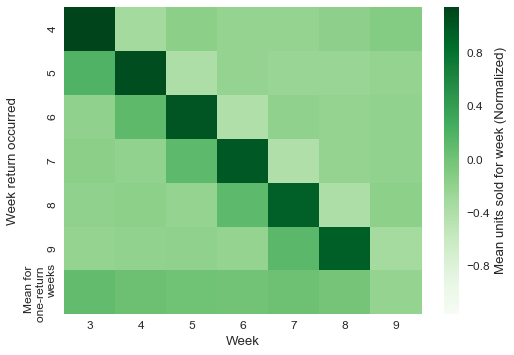

In [18]:
# Make a heatmap of sales relative to weeks where returns occurred, based on a sample 
# from the training set

one_return_sales_scaled = (one_return_sales-one_return_sales.mean(axis=1, keepdims=True)) / one_return_sales.std(axis=1, keepdims=True)
week_sales = np.zeros([7,7])
for rw in range(6):
    rows_for_week = (return_weeks==rw)
    values = np.nanmean(one_return_sales_scaled[rows_for_week],0)
    week_sales[rw,:] = values
week_sales[-1,:] = np.nanmean(one_return_sales_scaled,0)
plt.figure()
yticks = [str(a) for a in range(4,10)] + ["Mean for \none-return \nweeks"]
sns.set(font_scale=1.2)
ax = sns.heatmap(week_sales, cmap="Greens", annot=False, xticklabels=range(3,10), yticklabels=yticks)
plt.ylabel('Week return occurred')
plt.xlabel('Week')
cax = plt.gcf().axes[-1]
cax.set_ylabel('Mean units sold for week (Normalized)')
plt.draw()

This normalization has greatly smoothed the plot, and now shows clearly that there were lower sales during the week of returns, but higher sales one and two weeks before. Nevertheless, it's hard to see any clear drop in sales in the weeks after the return week.

## Conclusion
Returns are present in only a small percentage of training examples (3.4%), and do not appear to predict future sales in a consistent way. Therefore incorporating returns into a model, as opposed to simple demand, should provide only very small improvements to predictive power at best. 